In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter
import netwulf as nw

https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVcg

In [96]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])


In [ ]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

pop_df, rap_df = split_artists_by_genre(nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)


(16099, 7264)

In [98]:
def get_Graph(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Create a new graph
    G = nx.Graph()

    # Add nodes to the graph
    # Each node has the artist name as a label and spotify_id as the node identifier
    for _, row in nodes_df.iterrows():
        # Convert potential NaN values to appropriate types
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []
        
        G.add_node(row['spotify_id'], name=row['name'], followers=followers, 
                    popularity=popularity, genres=genres, chart_hits=chart_hits)

    # Add edges between artists
    for _, row in edges_df.iterrows():
        id_0 = row['id_0']
        id_1 = row['id_1']
        # Only add edge if both nodes exist in the graph
        if id_0 in G.nodes and id_1 in G.nodes:
            G.add_edge(id_0, id_1)
            
    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
        

In [ ]:
G_pop = get_Graph(pop_df, edges_df)
G_rap = get_Graph(rap_df, edges_df)

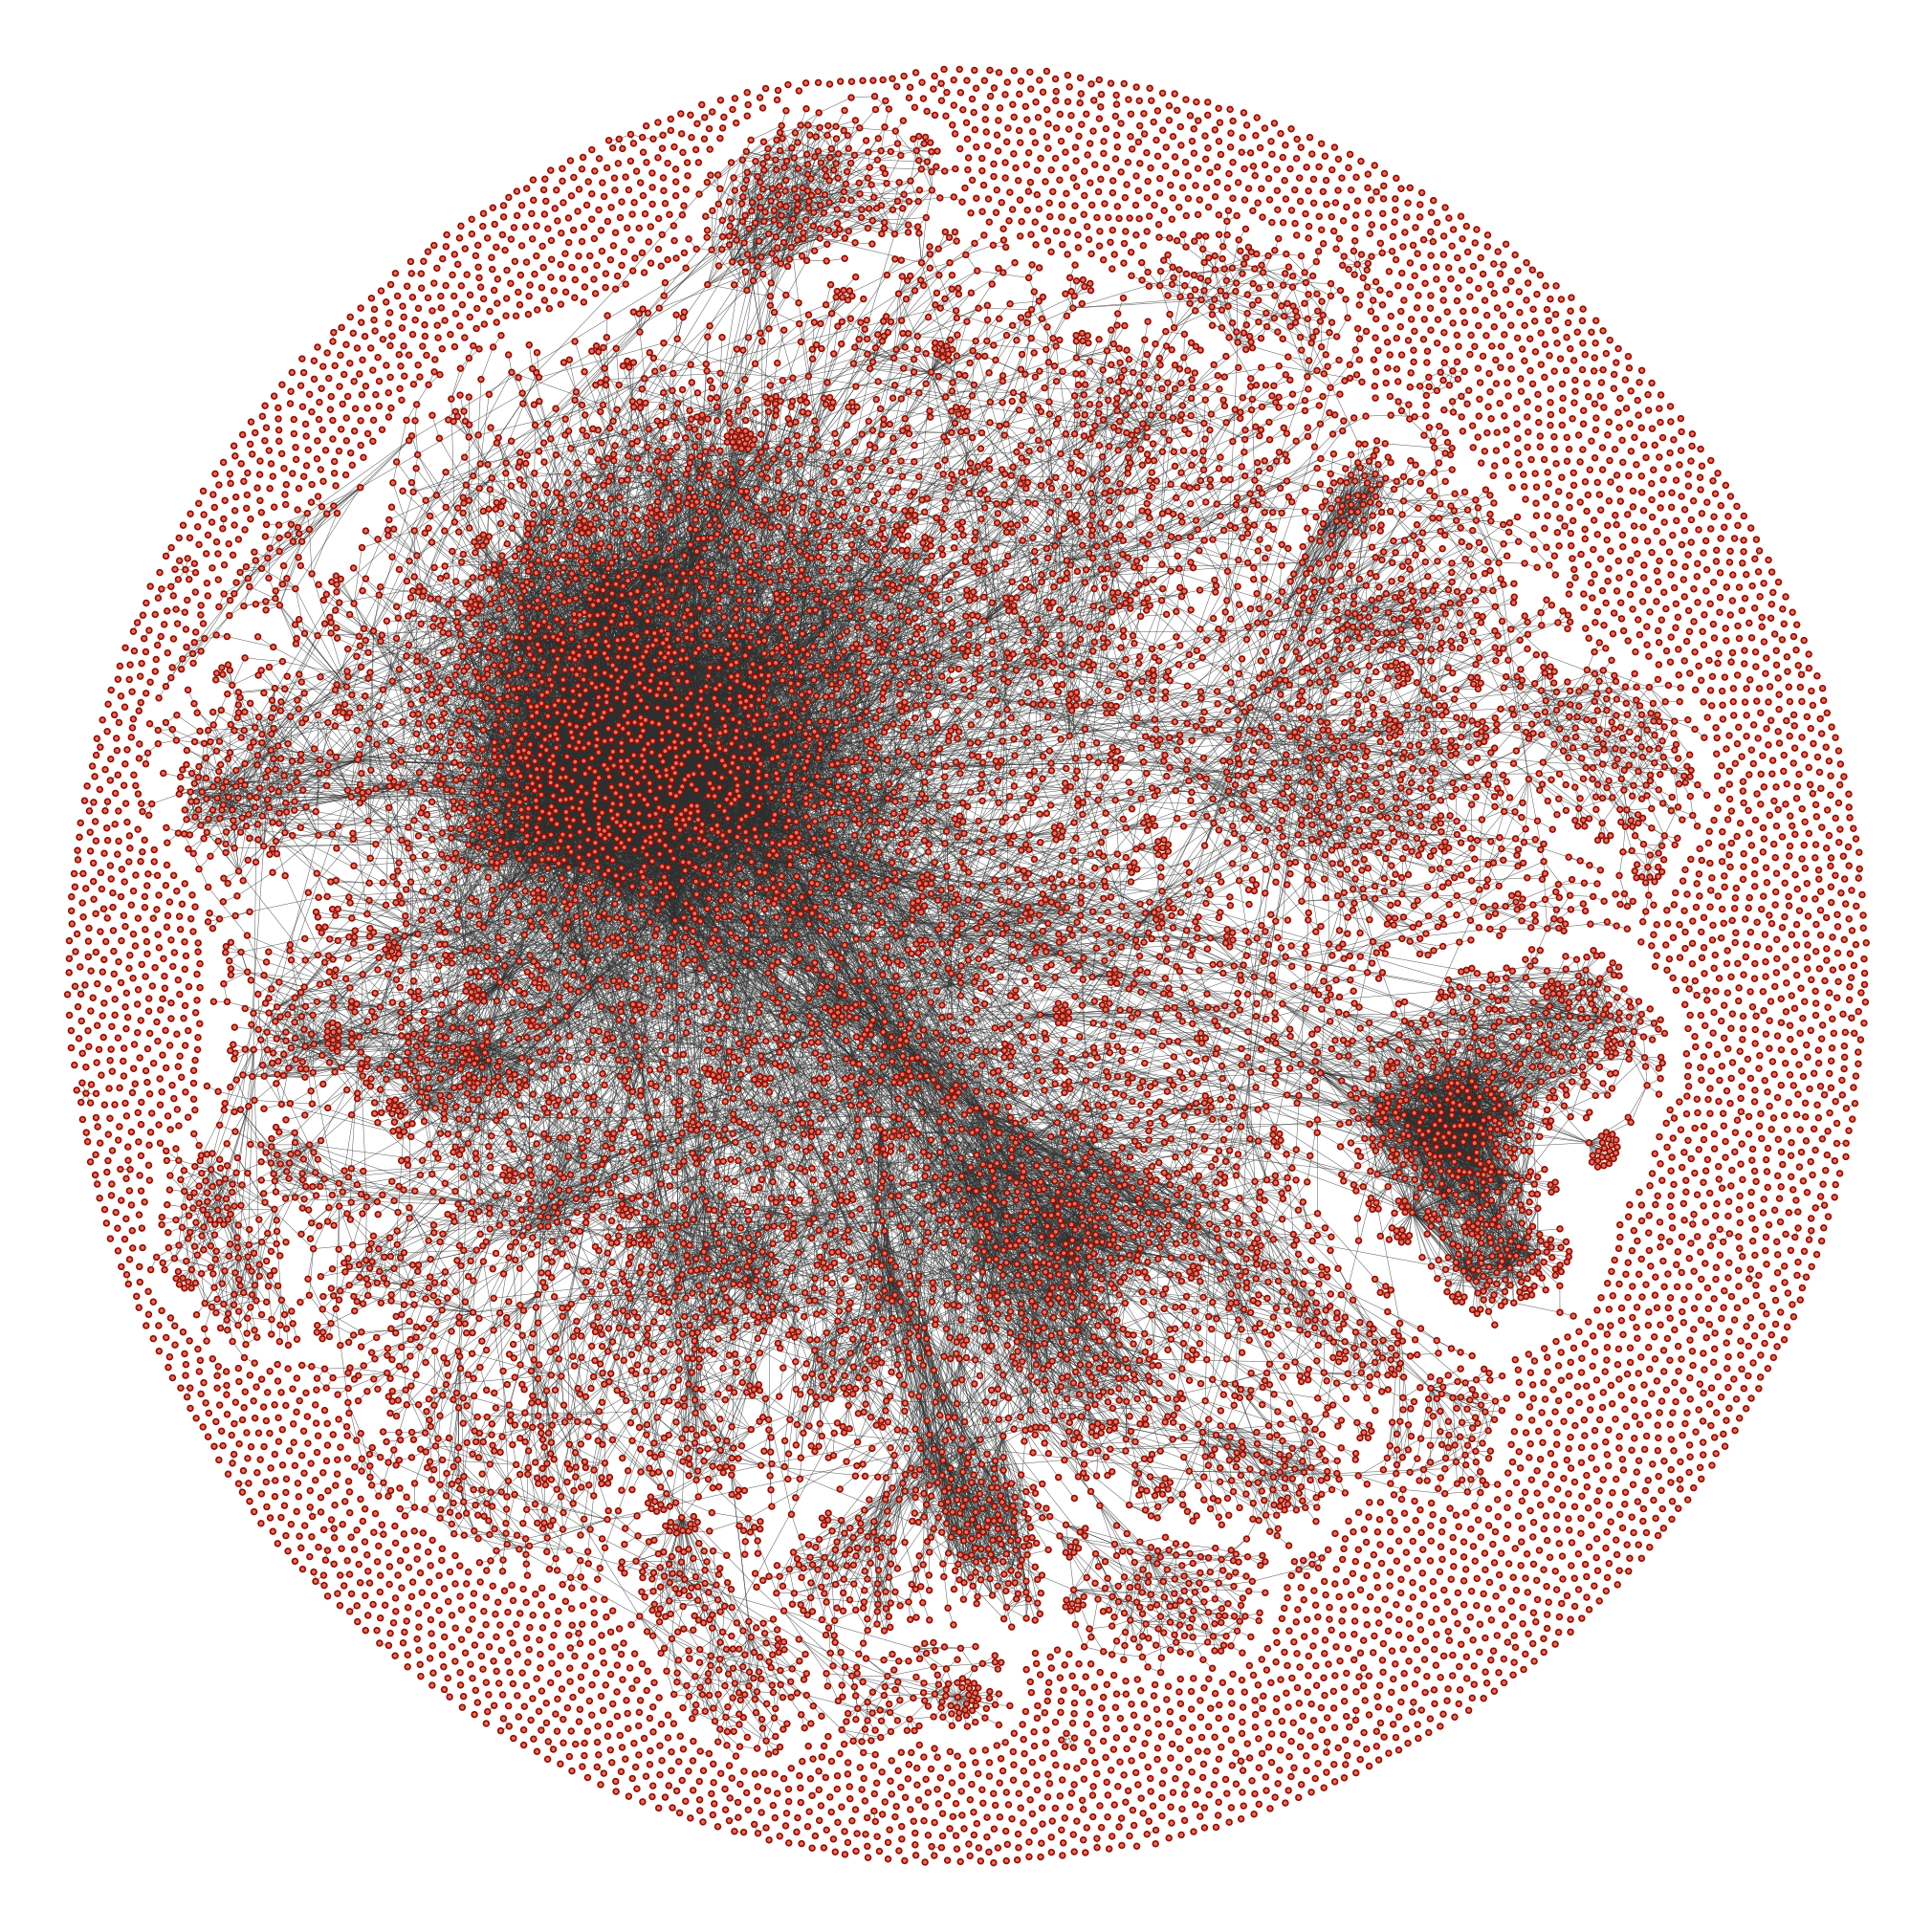

In [ ]:
config_random_network = {
    # Input/output
    'zoom': 0.6,
    # Physics
    'node_charge': -47,
    'node_gravity': 0.27,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    # Nodes
    'node_fill_color': '#e57468',
    'node_stroke_color': '#920e00',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': False,
    'node_size': 5,
    'node_stroke_width': 1,
    'node_size_variation': 0.5,
    # Links
    'link_color': '#2e2e2e',
    'link_width': 0.3,
    'link_alpha': 0.79,
    'link_width_variation': 0.5,
    # Thresholding
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1
}



network, config = nw.visualize(G_rap, plot_in_cell_below=False, config=config_random_network)

fig, ax = nw.draw_netwulf(G_rap, figsize=20)
plt.savefig("Network.pdf")


Number of nodes in subset: 1000
Number of edges in subset: 195
Network density of subset: 0.000390


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

C:\Users\teisa\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 12302 (\N{LEFT WHITE CORNER BRACKET}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\teisa\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 12518 (\N{KATAKANA LETTER YU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\teisa\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\teisa\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\teisa\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 12303 (\N{RIGHT WHITE CORNER BRACKET}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C

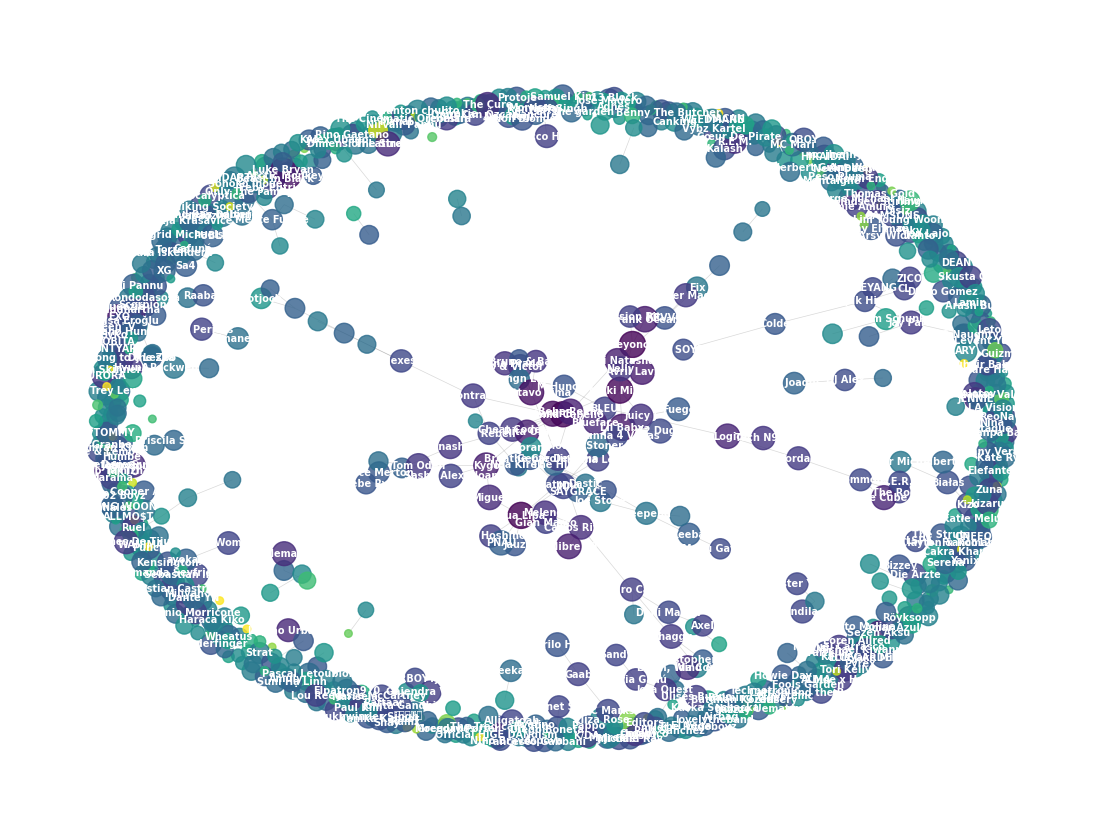

In [12]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def create_spotify_graph(nodes_file, edges_file, max_nodes=None):
    # Read CSV files and handle NaN values
    nodes_df = pd.read_csv(nodes_file)
    edges_df = pd.read_csv(edges_file)
    
    # Drop rows with NaN values in critical columns
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])
    
    # Limit to max_nodes if specified
    if max_nodes is not None and max_nodes < len(nodes_df):
        nodes_df = nodes_df.head(max_nodes)
    
    # Create a new graph
    G = nx.Graph()
    
    # Add nodes to the graph
    for _, row in nodes_df.iterrows():
        # Convert potential NaN values to appropriate types
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres'] if not pd.isna(row['genres']) else []
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []
        
        G.add_node(row['spotify_id'], name=row['name'], followers=followers, 
                  popularity=popularity, genres=genres, chart_hits=chart_hits)
    
    # Keep track of valid node ids
    valid_node_ids = set(G.nodes())
    
    # Add edges between artists (only if both nodes are in our subset)
    for _, row in edges_df.iterrows():
        id_0 = row['id_0']
        id_1 = row['id_1']
        # Only add edge if both nodes exist in the graph
        if id_0 in valid_node_ids and id_1 in valid_node_ids:
            G.add_edge(id_0, id_1)
    
    return G

def visualize_network(G, title="Spotify Artists Network (Subset)"):
    # Set up the figure with a black background
    plt.figure(figsize=(14, 10))
    plt.title(title, fontsize=18, color='white')
    plt.axis('off')
    
    # Use spring layout for force-directed placement
    layout = nx.spring_layout(G, k=0.2, iterations=100)  # Adjusted parameters for better spacing
    
    # Extract popularity values for node sizing
    popularity_values = [G.nodes[node].get('popularity', 30) for node in G.nodes()]
    # Convert to node sizes - scale popularity to make it visible
    node_sizes = [max(30, p * 4) for p in popularity_values]
    
    # Extract follower count for node color intensity
    follower_values = [np.log1p(G.nodes[node].get('followers', 1000)) for node in G.nodes()]
    
    # Create a colormap for the nodes based on follower count
    norm = plt.Normalize(min(follower_values), max(follower_values))
    color_map = plt.cm.viridis_r
    
    # Draw the network
    # Draw edges
    nx.draw_networkx_edges(G, layout, alpha=0.3, width=0.5, edge_color='gray')
    
    # Draw nodes
    nx.draw_networkx_nodes(G, layout, 
                         node_size=node_sizes,
                         node_color=follower_values, 
                         cmap=color_map,
                         alpha=0.8)
    
    # For a subset visualization, we can show more labels
    # Select nodes with higher popularity for labeling (adjusted threshold)
    high_popularity_nodes = {node: G.nodes[node]['name'] for node in G.nodes() 
                           if G.nodes[node].get('popularity', 0) > 50}
    
    nx.draw_networkx_labels(G, layout, 
                          labels=high_popularity_nodes, 
                          font_size=7, 
                          font_color='white',
                          font_weight='bold')
    
    # Add a colorbar to show the follower scale
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Log(Followers)', shrink=0.75, pad=0.05)
    
    # Set background color to black
    plt.gca().set_facecolor('black')
    plt.gcf().set_facecolor('black')
    
    # Add legend explaining the visualization
    plt.figtext(0.12, 0.01, "Node size: Artist popularity", 
              color='white', fontsize=10)
    plt.figtext(0.42, 0.01, "Node color: Number of followers (log scale)", 
              color='white', fontsize=10)
    plt.figtext(0.78, 0.01, "Labels: Artists with popularity > 50", 
              color='white', fontsize=10)
    
    # Calculate network metrics for this subset
    density = nx.density(G)
    average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    
    # Add network metrics to the plot
    plt.figtext(0.02, 0.98, f"Network Density: {density:.4f}", 
              color='white', fontsize=10)
    plt.figtext(0.02, 0.96, f"Avg. Connections per Artist: {average_degree:.2f}", 
              color='white', fontsize=10)
    plt.figtext(0.02, 0.94, f"Artists in Subset: {G.number_of_nodes()}", 
              color='white', fontsize=10)
    plt.figtext(0.02, 0.92, f"Connections in Subset: {G.number_of_edges()}", 
              color='white', fontsize=10)
    
    # Adjust layout to make room for the colorbar
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('spotify_network_subset.png', dpi=300, bbox_inches='tight', facecolor='black')
    
    plt.show()

# Create a graph with the first 1000 nodes
G = create_spotify_graph('nodes.csv', 'edges.csv', max_nodes=1000)

# Print some basic metrics about the subset graph
print(f"Number of nodes in subset: {G.number_of_nodes()}")
print(f"Number of edges in subset: {G.number_of_edges()}")
print(f"Network density of subset: {nx.density(G):.6f}")

# Visualize the network subset
visualize_network(G, title="Spotify Artists Network (First 1000 Artists)")

# Find connected components
connected_components = list(nx.connected_components(G))
print(f"Number of connected components: {len(connected_components)}")
print(f"Size of largest connected component: {len(max(connected_components, key=len))}")

# If there are too many isolated nodes, we might want to visualize only the connected ones
if len(connected_components) > 1:
    largest_cc = max(connected_components, key=len)
    G_largest_cc = G.subgraph(largest_cc)
    print(f"Visualizing largest connected component with {G_largest_cc.number_of_nodes()} nodes")
    visualize_network(G_largest_cc, title="Largest Connected Component (Subset)")